# Analyzing Time Series 
<hr style="border:2px solid black">

## 1. Introduction 

### 1.1 Time Series Data

>- ordered sequence of observations at equal intervals of time
>- no notion of independent and dependent variables
>- observations not independent of each other
>- may exhibit a variety of patterns

### 1.2 Time Series Components

- a time series may conveniently be split into several components
- each represents an underlying pattern category

>|  components |                         pattern                                   |
 |:-----------:|:-----------------------------------------------------------------:|
 |   `Trend`   |     long-term rises and falls not having periodic pattern         |
 |`Seasonality`|recurring pattern of fixed/known period (e.g., year, quarter, week)|
 | `Remainder` |      leftover time series devoid of trend and seasonality         |

### 1.3 Decomposition Types


>|      type      |           model                 |           suitable when            |
 |:--------------:|:-------------------------------:|:----------------------------------:|
 |   `Additive`   |    $$y_t = T_t + S_t + R_t$$    | variance fairly constant over time |
 |`Multiplicative`|$$y_t = S_t\times T_t\times R_t$$|variance changes significantly over time|

### Load Packages

In [55]:
# data analysis stack
import numpy as np
import pandas as pd
from datetime import datetime

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.linear_model import LinearRegression

# miscellaneous
import warnings
warnings.filterwarnings("ignore")


######################


import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### visualize the data 

In [56]:
# the txt-file contains information as seen above. therefore we skip the first 18 rows.
# more information ...
PATH = '/home/florianriemann/data_science_portfolio/boot_camp/data/data_temperature/'

df_temp = pd.read_csv(PATH + 'TG_STAID002759.txt', delimiter = ",", skiprows = 18)

In [57]:
df_temp.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [58]:
# rename the columns
df_temp.columns = ['id', 'date', 'temp', 'quality']

In [59]:
df_temp.head()

,id,date,temp,quality
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [60]:
# next change the datatype of the date and set the date as index
df_temp['date'] = df_temp['date'].astype(str)
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp         = df_temp.set_index("date")
df_temp.head()

,id,temp,quality
date,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [61]:
# data info
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53569 entries, 1876-01-01 to 2022-08-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       53569 non-null  int64
 1   temp     53569 non-null  int64
 2   quality  53569 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


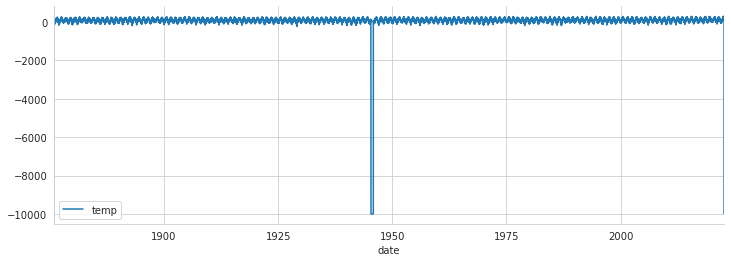

In [62]:
# ...
df_temp['temp'].plot(figsize=(12,4),legend=True)
sns.despine()

### train-test-split

In [63]:
data_train = df_temp.loc['2010':'2020']
data_train.info()
data_train.to_csv(PATH + "climate_train.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2010-01-01 to 2020-12-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       4018 non-null   int64
 1   temp     4018 non-null   int64
 2   quality  4018 non-null   int64
dtypes: int64(3)
memory usage: 125.6 KB


In [64]:
data_test = df_temp.loc['2021']
data_test.info()
data_test.to_csv(PATH + "climate_test.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       365 non-null    int64
 1   temp     365 non-null    int64
 2   quality  365 non-null    int64
dtypes: int64(3)
memory usage: 11.4 KB


<hr style="border:2px solid black">

### Model Trend

In [65]:
PATH

'/home/florianriemann/data_science_portfolio/boot_camp/data/data_temperature/'

In [66]:
train = pd.read_csv(PATH + 'climate_train.csv', index_col = 0, parse_dates = True)

In [67]:
train.head()

,id,temp,quality
date,,,
2010-01-01,111448,-14,0
2010-01-02,111448,-17,0
2010-01-03,111448,-43,0
2010-01-04,111448,-56,0
2010-01-05,111448,-60,0


In [68]:
# engineer timestep variable for future convenience

train['timestep'] = list(range(train.shape[0]))
train['t²'] = train['timestep']**2

In [69]:
train.head()

,id,temp,quality,timestep,t²
date,,,,,
2010-01-01,111448,-14,0,0,0
2010-01-02,111448,-17,0,1,1
2010-01-03,111448,-43,0,2,4
2010-01-04,111448,-56,0,3,9
2010-01-05,111448,-60,0,4,16


In [70]:
# feature and target for trend model

X_trend = train[['timestep','t²']]
y_trend = train['temp']

In [71]:
trend_model = LinearRegression()

# Fit a linear function of the timestep to data

trend_model.fit(X_trend, y_trend)

LinearRegression()

In [72]:
# predict from fitted model

train['trend'] = trend_model.predict(X_trend)

**Plot trend and original data**

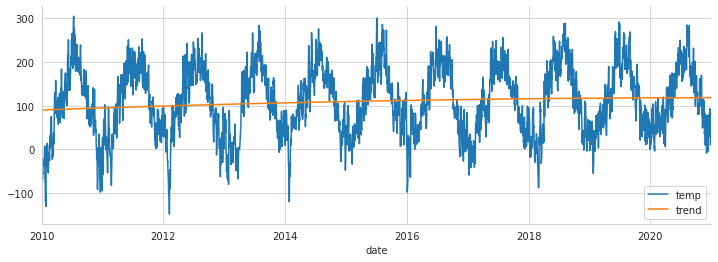

In [73]:
train[['temp','trend']].plot(figsize=(12,4),legend=True)
sns.despine()

***Q: How can we model a polynomial trend?***

A polynomial trend of the data, if needed, can be modeled by using [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) from `sklearn`

### Model Seasonality

In [74]:
# subtract trend from data

train['detrended'] = train['temp'] - train['trend']

In [75]:
train.head()

,id,temp,quality,timestep,t²,trend,detrended
date,,,,,,,
2010-01-01,111448,-14,0,0,0,90.206019,-104.206019
2010-01-02,111448,-17,0,1,1,90.219545,-107.219545
2010-01-03,111448,-43,0,2,4,90.233068,-133.233068
2010-01-04,111448,-56,0,3,9,90.246587,-146.246587
2010-01-05,111448,-60,0,4,16,90.260104,-150.260104


In [76]:
# create month column

train['month'] = train.index.month

In [77]:
# make dummy columns for months

seasonal_dummies = pd.get_dummies(
    train['month'], 
    prefix='month', 
    drop_first=True
).set_index(train.index)

In [78]:
# add dummy columns to our flights dataframe

train = pd.concat([train, seasonal_dummies], axis=1)

In [79]:
train.columns

Index(['id', 'temp', 'quality', 'timestep', 't²', 'trend', 'detrended',
       'month', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [80]:
train.head()

,id,temp,quality,timestep,t²,trend,detrended,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,
2010-01-01,111448,-14,0,0,0,90.206019,-104.206019,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-02,111448,-17,0,1,1,90.219545,-107.219545,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,111448,-43,0,2,4,90.233068,-133.233068,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,111448,-56,0,3,9,90.246587,-146.246587,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,111448,-60,0,4,16,90.260104,-150.260104,1,0,0,0,0,0,0,0,0,0,0,0


In [81]:
# feature and target for seasonality model

X_seasonality = train[train.columns[-11:]]
y_seasonality = train['detrended']

In [82]:
# fit seasonality model

seasonality_model = LinearRegression()
seasonality_model.fit(X_seasonality, y_seasonality)

LinearRegression()

In [83]:
# predict from fitted model

train['seasonality'] = seasonality_model.predict(X_seasonality)

**Plot seasonality and detrended data**

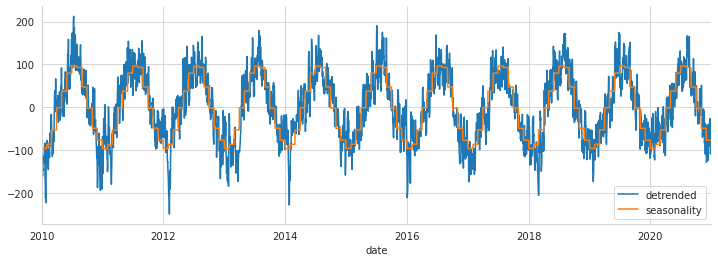

In [84]:
train[['detrended','seasonality']].plot(figsize=(12,4),legend=True)
sns.despine()

**Plot trend + seasonality and original data**

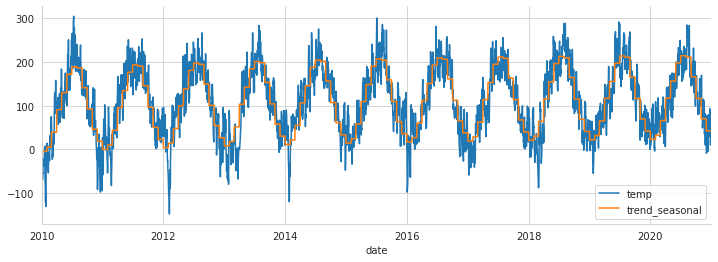

In [85]:
# combine trend and seasonality

train['trend_seasonal'] = train['trend'] + train['seasonality']

train[['temp','trend_seasonal']].plot(figsize=(12,4),legend=True)
sns.despine()

### Extract Remainder

In [86]:
# leftover time series devoid of trend and seasonality

train['remainder'] = train['temp'] - train['trend_seasonal']

**Plot remainder**

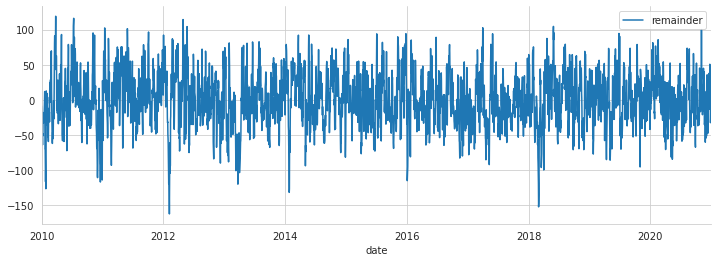

In [87]:
train['remainder'].plot(figsize=(12,4),legend=True)
sns.despine()

- ***Is there any information stored in the remainder?***
- ***If yes, how to extract this in order to build a better model?***

**Save reminder for further analysis**

In [88]:
# df_remaider = train['remainder'].reset_index()
# df_remaider.to_csv('../data/milk_remainder.csv',index=False)

# train_remainder = train['remainder'].reset_index()
# train_remainder.to_csv(PATH + 'train_remainder.csv',index = False)

<hr style="border:2px solid black">

In [89]:
train['remainder']

date
2010-01-01    -8.851831
2010-01-02   -11.865357
2010-01-03   -37.878880
2010-01-04   -50.892400
2010-01-05   -54.905916
                ...    
2020-12-27   -26.342923
2020-12-28   -14.343477
2020-12-29   -19.344029
2020-12-30   -17.344577
2020-12-31   -16.345122
Name: remainder, Length: 4018, dtype: float64

### Is this data stationary ??

In [90]:
train['remainder']

date
2010-01-01    -8.851831
2010-01-02   -11.865357
2010-01-03   -37.878880
2010-01-04   -50.892400
2010-01-05   -54.905916
                ...    
2020-12-27   -26.342923
2020-12-28   -14.343477
2020-12-29   -19.344029
2020-12-30   -17.344577
2020-12-31   -16.345122
Name: remainder, Length: 4018, dtype: float64

In [91]:
# get more information about ADF: https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/
# apply the Augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

In [92]:
print_adf(train['remainder'])

 
              adf_stats: -19.034928277909447
              p: 0.0 
              used lag: 3 
              number of observations: 4014
            
              CI 99%: -3.4319801661169578
              CI 95%: -2.862260318209578
              CI 90%: -2.5671534329349024
              information criterion (AIC): 35931.56209916163
            


In [93]:
# i.e. a small p value, less than 0.05, means that you have a stationary series ...
# this means the time series is stationary
# Note: The more negative the DF test statistic, the stronger the evidence for rejecting the null hypothesis of a unit root.

In [94]:
#Ho - null hypothesis: series is non stationary
#H1 - alternative hypothesis: series is stationary

def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")


In [95]:
adfuller_test(train['remainder'])

ADF Test Statistic : -19.034928277909447
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 4014
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### Inspect the Partial Autocorrelation (Box-Jenkins-Methodology)

In [96]:
# https://machinelearningmastery.com/time-series-data-stationary-python/

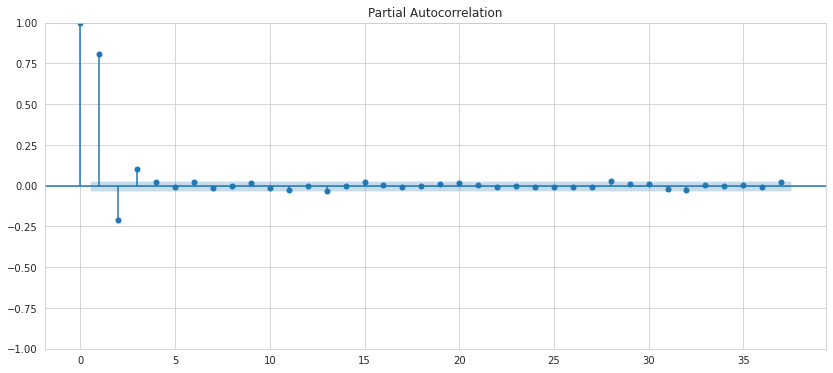

In [97]:
# Plot the partial autocorrelation function
plot_pacf(train['remainder']);

plt.show()

### Q: Inspecting the pacf plot we choose to include ? lags into our model ? How can we be additionally sure ?

In [98]:
# Use ar_select_order - brute force method that tries different models and takes the best one

order = ar_select_order(train['remainder'], maxlag=40, old_names=False)

In [99]:
# How many lags does ar_select_order suggest?

order.ar_lags

[1, 2, 3]

### Build a AR model with the right number of lags

Everything points us towards using 3 to 4 lags for our model

In [100]:
# Fit a statsmodels AutoReg model
# pure autoregressive model: AR4
ar_model = AutoReg(train['remainder'], lags = 4, old_names = False).fit()

In [101]:
ar_model.predict()

2010-01-01          NaN
2010-01-02          NaN
2010-01-03          NaN
2010-01-04          NaN
2010-01-05   -40.315449
                ...    
2020-12-27   -24.641692
2020-12-28   -17.040818
2020-12-29    -9.247993
2020-12-30   -17.765446
2020-12-31   -13.142096
Freq: D, Length: 4018, dtype: float64

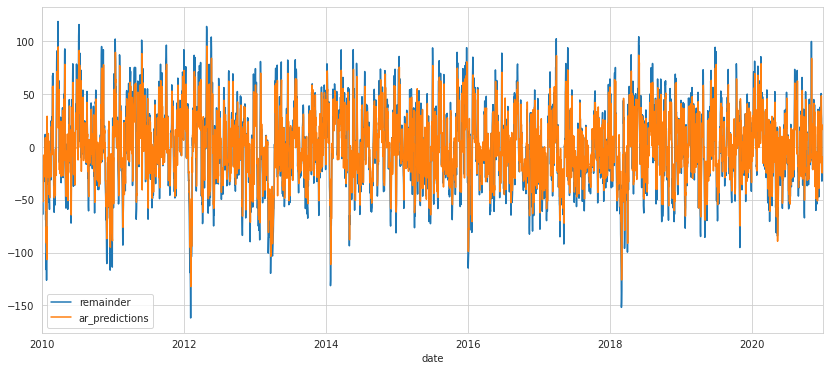

In [102]:
# Plot the prediction

train['remainder'].plot()
plt.plot(ar_model.predict(), label = 'ar_predictions') # insample prediction
plt.legend()
plt.show()

### Looks good, can we do better?

### ARIMA - Autoregressive Integrated Moving Average

With the AR model we found a quite decent model for our data. The question is, can we do even better? 

One way we might be able to improve our model is by including a **Moving Average part (MA)** into the model, if it exists

Simply speaking the **MA** part is just a different way of modeling time dependence. Instead of using past values of the variable itself we will **use past prediction errors to predict the future**. Mathematically this looks like:

### 1) AR(p)

The $AR(p)$ part is just an autoregressive part of the model where *p* denotes the number of lags to include.

### 2) I(d)

The $I(d)$ part is just the part where the model is detrended. *d* determines which order of differencing should be applied to the original time series data before modelling the AR and MA parts

If the data is stationary, then $d = 0$

### 3) MA(q)

This is the new part that we have not seen before. Instead of regressing on past lags, the Moving Average approach regresses on past errors:

**MA(1):** $\hat{y_{t+1}} = b + \phi*\epsilon_{t}$

where $\epsilon_{t} = \hat{y_{t}} - y_{t} $

or adding more features (lags):

**MA(2):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + \phi_2*\epsilon_{t-1}$

or adding more features (lags):

**MA(q):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + ... + \phi_q*\epsilon_{t-q-1}$


### How do we determine the order of the MA term q?

Instead of looking at the partial autocorrelation as was the case for the AR model we can look at the autocorrelation between observations $y_t$ and $y_{t-h}$.

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})}{\sqrt{V(y_t)*V(y_{t-h})}}
$$

**What does the Box-Jenkins method say here?**

#### Value of q

The value of q is found from the autocorrelations plot as follows:


- If the autocorrelations cut off after a few lags, the last lag with a large value would be the estimated value of q
- If the autocorrelations do not cut off, but rather decay gradually, you either have an autoregressive model (q=0) or an ARIMA model with a positive p and q

[source](https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf)

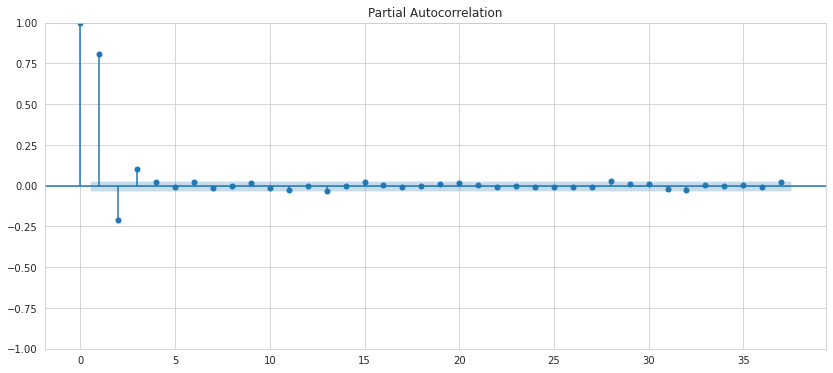

In [103]:
# let's examine both plots now

plot_pacf(train['remainder']);

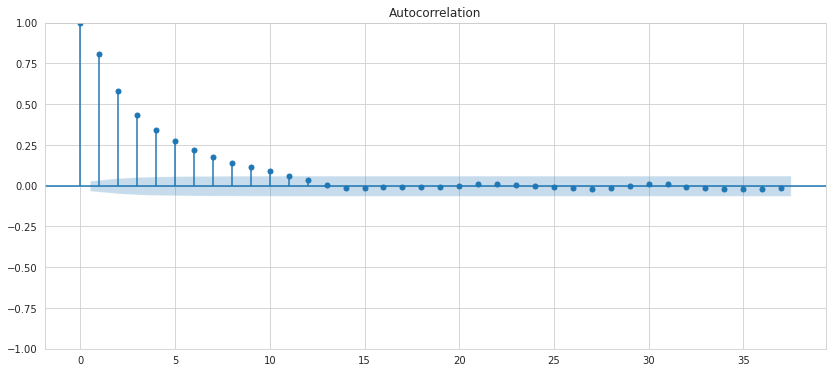

In [104]:
plot_acf(train['remainder']);

Analogous to the plot of the partial autocorrelation for the AR part of the model, the plot of the autocorrelation function gives us an idea which lag to chose for the MA. If there is no clear cutoff this could mean

- That the time series is better modelled by a pure AR model
- That the time series is best modelled by a model including AR and MA terms (ARIMA)

### How to read the ACF-plot and the PACF-plot

Interpretation:

- If the ACF-Plot is showing an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag, we conclude that the data is best modelled by an AR(p) process. p is given by the last meaningful lag in the PACF-Plot.

### **AR process**

ACF-Plot AR(1)             |  PACF-Plot AR(1)
:-------------------------:|:-------------------------:
![](./images/acf_ar.png)   |  ![](./images/pacf_ar.png)

- If the ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay, we conclude that the data is best modelled by an MA(q) process. q is given by the last meaningful lag in the ACF-Plot.

---

### **MA process**

ACF-Plot MA(1)             |  PACF-Plot MA(1)
:-------------------------:|:-------------------------:
![](./images/acf_ma.png)   |  ![](./images/pacf_ma.png)

- If both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay, we conclude that the data is best modelled by an ARIMA(p,d,q) process. p and q cannot be inferred from the plots. Usually you would use an iterrative approach and try different combinations to find the best model. (eg. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

---

### **ARIMA process**

ACF-Plot ARIMA(1,0,1)      |  PACF-Plot ARIMA(1,0,1)
:-------------------------:|:-------------------------:
![](./images/acf_arima.png)|  ![](./images/pacf_arima.png)

### How do I determine which model to choose?

1. test stationarity
2. plot pacf and acf
3. determine possible ranges for p and q values
4. Fit all possible combinations (p,0,q) models and compare them. 
   Models with lower AIC/BIC score are better at explaining the data we have
    

#### What do AIC and BIC mean ? https://www.youtube.com/watch?v=McEN54l3EPU

### Other option: brute force; run multiple models with several combinations of p and q and choose the best one where best is usuall measured in terms of AIC

In [105]:
#!pip install pmdarima

In [106]:
from pmdarima.arima import auto_arima

In [107]:
# ARIMA(p,d,q)

# p = number of AR lags
# q = number of MA lags
# d = the order of integration (if the data is stationary, d=0)

auto_arima_model = auto_arima(train['remainder'], start_p=0, start_q=0, 
                              max_p=10, max_q=10, d=0)

In [108]:
auto_arima_model

ARIMA(order=(4, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Step1: inspect the time series by plotting

- does the series have a trend ?
- does the series have seasonality ?
- is the series stationary ?

<AxesSubplot:xlabel='date'>

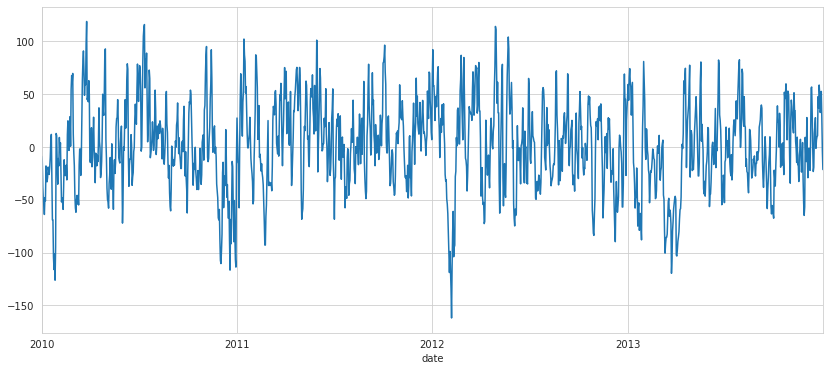

In [109]:
train['remainder'].loc['2010':'2013'].plot()

In [110]:
### we can already see that there is trend and seasonality in the series, meaning it is non-stationary

test_result = adfuller(train['remainder'])

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

ADF Statistic: -19.034928
p-value: 0.000000


In [111]:
#Ho - null hypothesis: series is non stationary
#H1 - alternative hypothesis: series is stationary

def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
adfuller_test(train['remainder'])

ADF Test Statistic : -19.034928277909447
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 4014
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### Step 2: Make time series stationary

Why??? This enables us to find the right model order (p,d,q) for our series!

In [112]:
# what to do if the time seris has a trend ?

train['diff1'] = train['remainder'].diff(1)

In [113]:
train = train[['remainder','diff1']]

In [114]:
train

,remainder,diff1
date,,
2010-01-01,-8.851831,NaN
2010-01-02,-11.865357,-3.013526
2010-01-03,-37.878880,-26.013523
2010-01-04,-50.892400,-13.013520
2010-01-05,-54.905916,-4.013516
...,...,...
2020-12-27,-26.342923,5.999442
2020-12-28,-14.343477,11.999445
2020-12-29,-19.344029,-5.000551


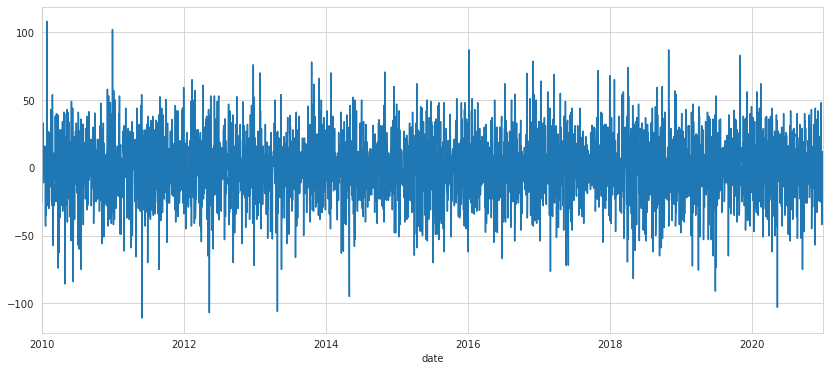

In [115]:
# plot the differenced signal and inspect results of adfuller test
train['diff1'].plot();

In [116]:
adfuller_test(train['diff1'].dropna())

ADF Test Statistic : -18.871539648729154
p-value : 0.0
#Lags Used : 28
Number of Observations Used : 3988
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


#### up till here, we can say that d = 1 and for now ignore the seasonality

####  Note 1: Even though the adfuller test p-value is less than 0.05, it is very close to that value. In this case, the reason is that there is seasonality in the time series that we did not yet extract. We will circle back to this in Seasonal ARIMA (SARIMA)

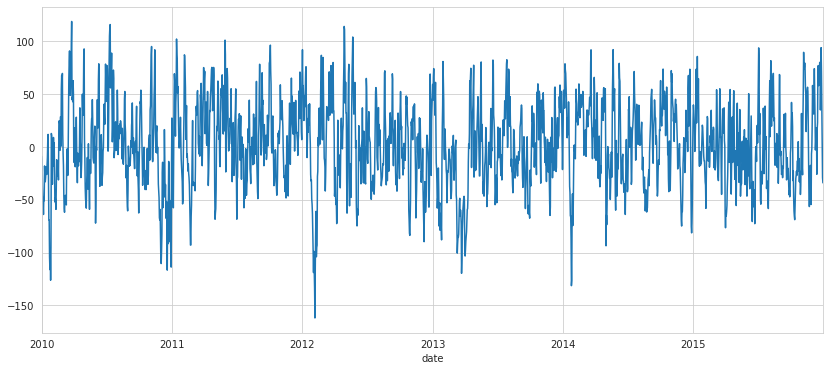

In [117]:
# inspecting the period of seasonality in the data
train['remainder'].loc['2010':'2015'].plot();

**conclusion: there is a period of 12 (12 months of the year) after which the series have the same shape**

In [118]:
## What to do if the series has seasonality ??
## period m = 12 is the period of my seasonality

train['seasonal_diff1'] = train['diff1'].diff(12)   # what does diff method do? 

train.head(20)

,remainder,diff1,seasonal_diff1
date,,,
2010-01-01,-8.851831,NaN,NaN
2010-01-02,-11.865357,-3.013526,NaN
2010-01-03,-37.878880,-26.013523,NaN
2010-01-04,-50.892400,-13.013520,NaN
2010-01-05,-54.905916,-4.013516,NaN
2010-01-06,-63.919429,-9.013513,NaN
2010-01-07,-47.932939,15.986490,NaN
2010-01-08,-50.946446,-3.013507,NaN
2010-01-09,-17.959949,32.986497,NaN


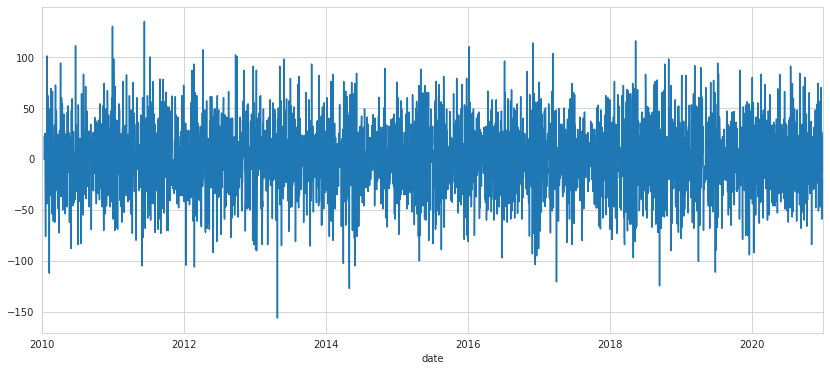

In [119]:
# plot the first seasonal difference 

train['seasonal_diff1'].plot();

In [120]:
# check results of adfuller test

adfuller_test(train['seasonal_diff1'].dropna())

ADF Test Statistic : -21.87179351495359
p-value : 0.0
#Lags Used : 30
Number of Observations Used : 3974
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### step 3: Let's look at the acf and pacf plots (of the stationary differenced data)

#### A: checking only the detrended data

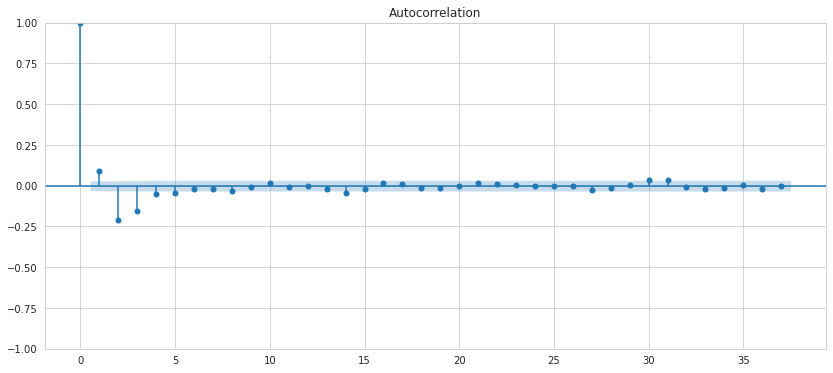

In [121]:
plot_acf(train['diff1'].dropna());

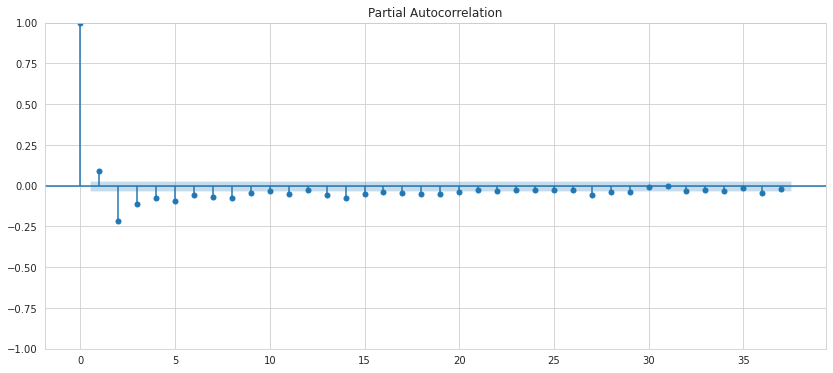

In [122]:
plot_pacf(train['diff1'].dropna());

#### checking the seasonal differenced series (trend and seasonality both taken out)

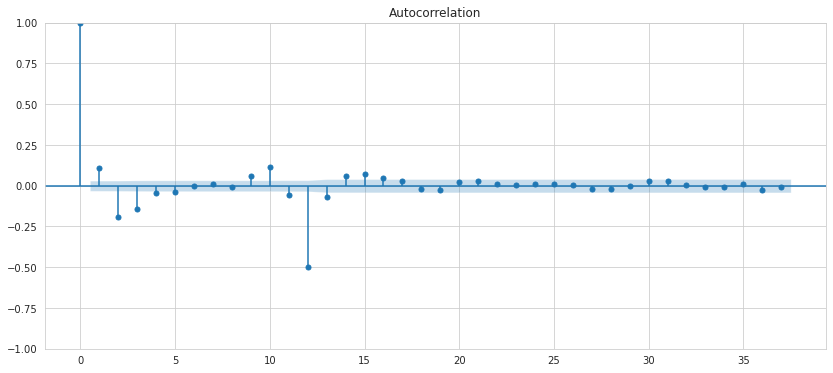

In [123]:
plot_acf(train['seasonal_diff1'].dropna());

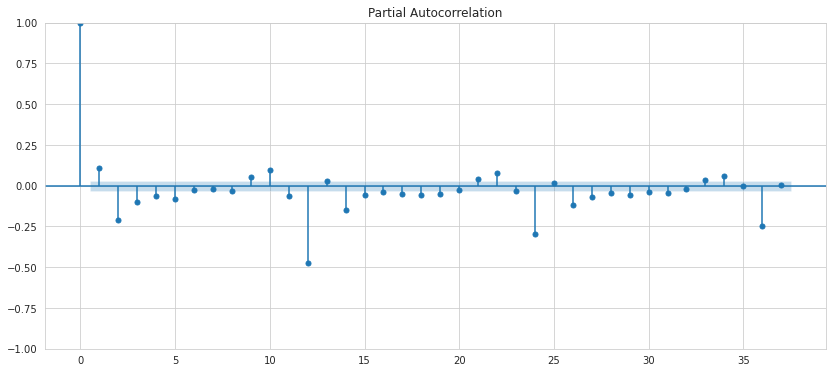

In [124]:
plot_pacf(train['seasonal_diff1'].dropna());

### step 4: Attempt multiple models and choose the best

#### we will ignore the seasonality now and go with an ARIMA model that does not take seasonality in consideration

In [125]:
train = pd.read_csv(PATH + 'climate_train.csv', index_col = 0, parse_dates = True)

In [126]:
train.head()

,id,temp,quality
date,,,
2010-01-01,111448,-14,0
2010-01-02,111448,-17,0
2010-01-03,111448,-43,0
2010-01-04,111448,-56,0
2010-01-05,111448,-60,0


In [127]:
from pmdarima.arima import auto_arima

In [128]:
auto_arima_model = auto_arima(train['temp'], 
                              start_p=0, start_q=0, 
                              max_p=10, max_q=10, max_d=2)

In [129]:
auto_arima_model

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [130]:
# fit and ARIMA (3,1,1) model (p,d,q)

model = ARIMA(train['temp'], order=(3,1,1)).fit()

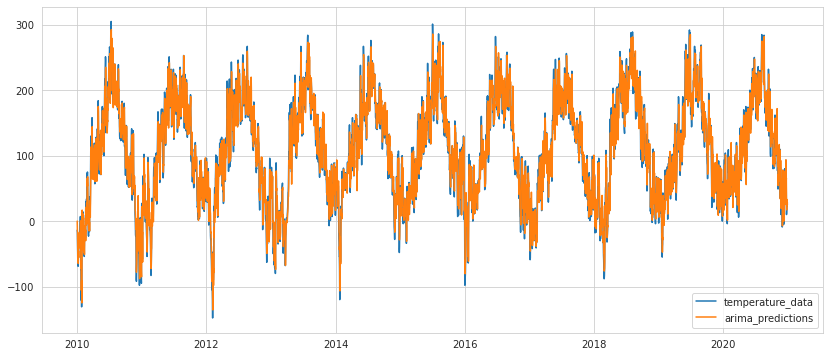

In [131]:
plt.plot(train['temp'], label='temperature_data')
plt.plot(model.predict(), label='arima_predictions')  # this is called in-sample predictions, predictions on test data
plt.legend();

In [132]:
# calculate rmse on training data
import numpy as np
rmse_no_seasonality = np.sqrt(mean_squared_error(train['temp'], model.predict()))

rmse_no_seasonality

21.614051115847968

### So how can we check model behavior on unseen data ? How can we use the model to forecast?

In [133]:
train.tail()

,id,temp,quality
date,,,
2020-12-27,111448,16,0
2020-12-28,111448,28,0
2020-12-29,111448,23,0
2020-12-30,111448,25,0
2020-12-31,111448,26,0


### a) One step out-of-sample prediction

In [134]:
model.forecast()

2021-01-01    28.006882
Freq: D, dtype: float64

### b) Multiple steps out-of-sample predictions

In [135]:
model.predict(start='2021-01-01', end='2021-01-31')

2021-01-01    28.006882
2021-01-02    29.741704
2021-01-03    30.823076
2021-01-04    31.458219
2021-01-05    31.857094
2021-01-06    32.120734
2021-01-07    32.295059
2021-01-08    32.408635
2021-01-09    32.482138
2021-01-10    32.529770
2021-01-11    32.560718
2021-01-12    32.580842
2021-01-13    32.593920
2021-01-14    32.602417
2021-01-15    32.607937
2021-01-16    32.611523
2021-01-17    32.613853
2021-01-18    32.615367
2021-01-19    32.616351
2021-01-20    32.616990
2021-01-21    32.617405
2021-01-22    32.617675
2021-01-23    32.617850
2021-01-24    32.617964
2021-01-25    32.618038
2021-01-26    32.618086
2021-01-27    32.618118
2021-01-28    32.618138
2021-01-29    32.618151
2021-01-30    32.618160
2021-01-31    32.618165
Freq: D, Name: predicted_mean, dtype: float64

In [136]:
test = pd.read_csv(PATH + 'climate_test.csv', index_col = 0, parse_dates = True)

In [137]:
test

,id,temp,quality
date,,,
2021-01-01,111448,21,0
2021-01-02,111448,11,0
2021-01-03,111448,6,0
2021-01-04,111448,8,0
2021-01-05,111448,17,0
...,...,...,...
2021-12-27,111448,-39,0
2021-12-28,111448,-5,0
2021-12-29,111448,45,0


In [138]:
# add predictions from both models

test['arima_predictions'] = model.predict(start='2021-01-01', end='2021-12-31').values

In [139]:
test

,id,temp,quality,arima_predictions
date,,,,
2021-01-01,111448,21,0,28.006882
2021-01-02,111448,11,0,29.741704
2021-01-03,111448,6,0,30.823076
2021-01-04,111448,8,0,31.458219
2021-01-05,111448,17,0,31.857094
...,...,...,...,...
2021-12-27,111448,-39,0,32.618175
2021-12-28,111448,-5,0,32.618175
2021-12-29,111448,45,0,32.618175


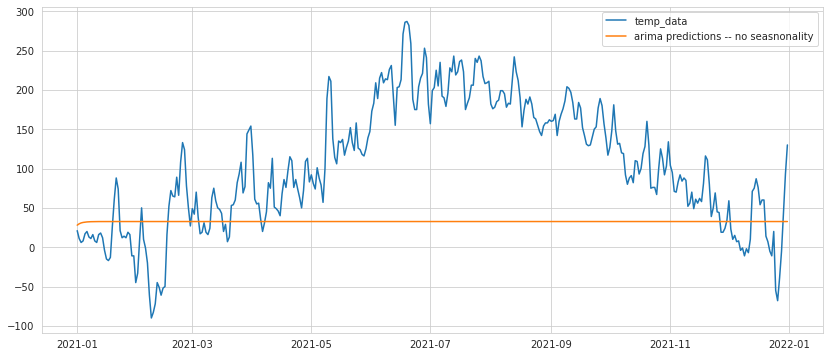

In [140]:
plt.plot(test['temp'], label='temp_data')
plt.plot(test['arima_predictions'], label='arima predictions -- no seasnonality')
plt.legend();

In [141]:
test_rmse_no_seasonality = np.sqrt(mean_squared_error(test['temp'], test['arima_predictions']))

test_rmse_no_seasonality

107.3415459927716

In [142]:
# the seasonal arima has 7 different hyperparameters: (p,d,q)(P,D,Q,m)
# m here is the series period, which we know is 12
# we can also use auto_arima to help us identify the best model


auto_arima_model = auto_arima(train['temp'], start_p=0, start_q=0, max_p=10, max_q=10, max_d=2, 
                              seasonal=True, start_P=0, start_Q=0, max_D=2, m=12, max_P=10, max_Q=10,
                              trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=36526.416, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=36490.403, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=36464.292, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=36524.417, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=36462.307, Time=0.35 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=36464.292, Time=1.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=36466.280, Time=1.91 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=36423.636, Time=0.37 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=36425.626, Time=1.53 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=36425.626, Time=2.15 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=36427.615, Time=3.62 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=36488.405, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=36121.802, Time=0.90 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=36123.377, Time=3.37 sec
 ARIM

In [ ]:
auto_arima_model

In [144]:
### introducing SARIMAX to handle seasonailty and hopefully get a better model (measure by rmse on test data)

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [145]:
sarima_model = SARIMAX(train['temp'], 
                       order=(3,1,1), seasonal_order=(0,0,0,12)).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50773D+00    |proj g|=  6.60850D-03

At iterate    5    f=  4.50433D+00    |proj g|=  8.28856D-02

At iterate   10    f=  4.49200D+00    |proj g|=  2.21846D-02

At iterate   15    f=  4.49135D+00    |proj g|=  3.26483D-03

At iterate   20    f=  4.49126D+00    |proj g|=  7.60609D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   7.606D-06   4.491D+00
  F =   4.4912592966189138     

CONVERG

In [146]:
# calculate train error

rmse_sarima = np.sqrt(mean_squared_error(train['temp'], 
                                         sarima_model.predict()))

In [147]:
rmse_sarima

21.614051115847968

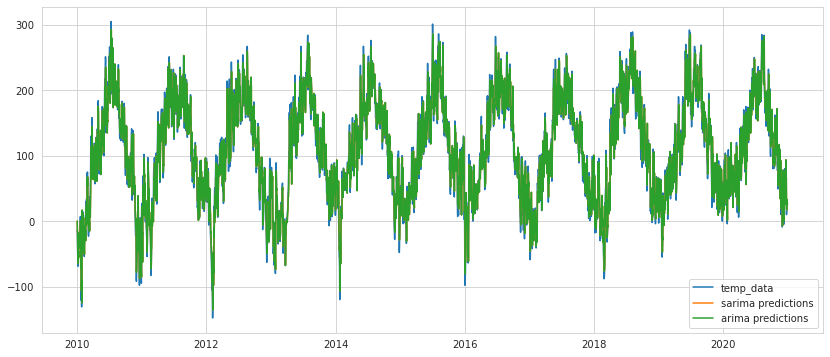

In [150]:
plt.plot(train['temp'], label='temp_data')
plt.plot(sarima_model.predict(), label='sarima predictions')
plt.plot(model.predict(), label='arima predictions')
plt.legend()

plt.show()

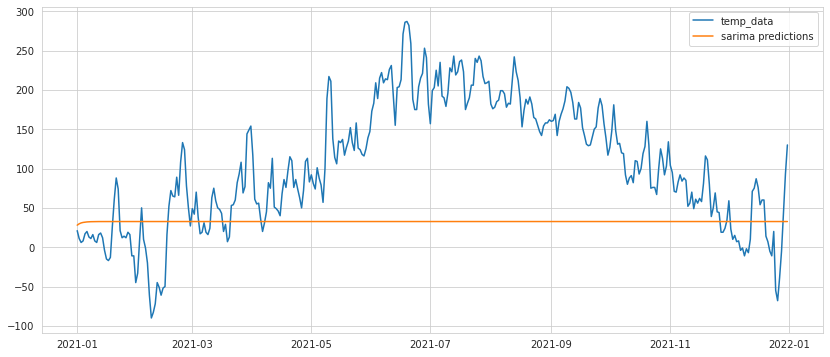

In [152]:
test['sarima_predictions'] = sarima_model.predict(start='2021-01-01', end='2021-12-31')

plt.plot(test['temp'], label='temp_data')
plt.plot(test['sarima_predictions'], label='sarima predictions')
plt.plot(test['arima_predictions'], label='arima predictions')
plt.legend()

plt.show()

### ....

### Decomposition with `statsmodel`

`pip install statsmodels`

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

[`statsmodel`](https://www.statsmodels.org/stable/index.html)
- Python module for various statistical model estimation, statistical tests, and statistical data exploration

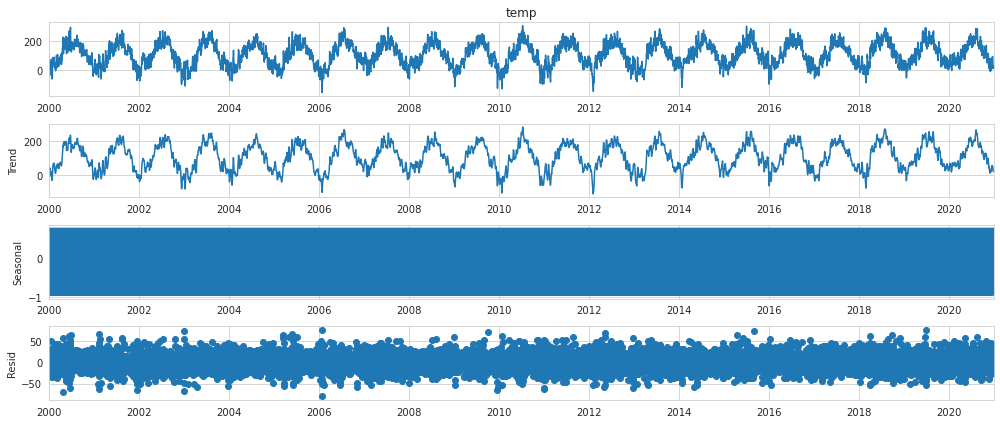

In [39]:
sd = seasonal_decompose(train['temp'], model='additive')

plt.rcParams['figure.figsize'] = (14,6)
sd.plot();

<hr style="border:2px solid black">

## References

- Forecasting: Principles and Practice, R. J. Hyndman & G. Athanasopoulos,
[OTexts Free Online Book](https://otexts.com/fpp3/)
- [Different types of Time Series Decomposition](https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693)
- [Some excellent youtube videos](https://www.youtube.com/watch?v=Prpu_U5tKkE)